# Evaluation of Stack Overflow Relevant Posts Retriever

In [2]:
import os
import json
import requests
import pandas as pd
from tqdm import tqdm
from time import sleep

# Custom modules
import lib.global_settings as settings
from ShaDoC.stackoverflow import retrieval
from ShaDoC.intent import question_intent_identifier
from ShaDoC.lib.api import StackExchange
from ShaDoC.lib.utils import split

API_KEY = "BmopG%29d9Thccirg4e%29CjOw%28%28"

import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
eval_data = pd.read_csv(os.path.join(settings.DATA_PATH, "ragas_user_eval_dataset.csv"))
eval_data.head()

,User,QuestionId,QuestionAPI,IssueType,Title,Question,GroundTruth
0,1,51586693,tf.gather,Documentation Replication on Other Examples,"Tensor has shape [?, 0] -- how to reshape to [?,]",<p>When <code>src</code> has shape <code>[?]</...,"<p>I think you should use <a href=""https://www..."
1,1,56286350,tf.keras.metrics.SensitivityAtSpecificity,Documentation Replication on Other Examples,tf.keras.metrics.SpecificityAtSensitivity num_...,"<p>I'm trying to get my head around <a href=""h...",<p>The <code>num_thresholds</code> refers to t...
2,1,74005009,tf.data.Dataset,Documentation Replicability,How to create output_signature for tensorflow....,<p>I have a generator yielding data and labels...,<p>if your datagen_row() function yields input...
3,1,51858970,tf.gradients,Documentation Ambiguity,"tf.gradients() sums over ys, does it?","<p><a href=""https://www.tensorflow.org/version...",<p>If y and x have the same shape then the sum...
4,1,60013980,tf.nn.embedding_lookup_sparse,Documentation Replicability,tf.nn.embedding_lookup_sparse 3D sparse tensor...,<p>I have an embedding matrix and there is a 3...,<p>The most easier way to do so is to make the...


In [3]:
# Unique questions
df = eval_data.drop_duplicates(subset=['QuestionId'], keep='first')
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(50, 7)


,User,QuestionId,QuestionAPI,IssueType,Title,Question,GroundTruth
0,1,51586693,tf.gather,Documentation Replication on Other Examples,"Tensor has shape [?, 0] -- how to reshape to [?,]",<p>When <code>src</code> has shape <code>[?]</...,"<p>I think you should use <a href=""https://www..."
1,1,56286350,tf.keras.metrics.SensitivityAtSpecificity,Documentation Replication on Other Examples,tf.keras.metrics.SpecificityAtSensitivity num_...,"<p>I'm trying to get my head around <a href=""h...",<p>The <code>num_thresholds</code> refers to t...
2,1,74005009,tf.data.Dataset,Documentation Replicability,How to create output_signature for tensorflow....,<p>I have a generator yielding data and labels...,<p>if your datagen_row() function yields input...
3,1,51858970,tf.gradients,Documentation Ambiguity,"tf.gradients() sums over ys, does it?","<p><a href=""https://www.tensorflow.org/version...",<p>If y and x have the same shape then the sum...
4,1,60013980,tf.nn.embedding_lookup_sparse,Documentation Replicability,tf.nn.embedding_lookup_sparse 3D sparse tensor...,<p>I have an embedding matrix and there is a 3...,<p>The most easier way to do so is to make the...


In [8]:

# Create a Stack Exchange class object
SE = StackExchange()

related_ids = []
related_answers = []

relevant_ids = []
relevant_answers = []
relevant_urls = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # URL to retrieve the related questions from the stackexchange api based on the question id
    response = SE.related_questions_based_on_id(row['QuestionId'])

    q_ids = set()
    results = []
    if response['items']:
        for i in range(len(response['items'])):
            if response['items'][i]['answer_count'] > 0:
                q_ids.add(response['items'][i]['question_id'])

        split_list = list(split(list(q_ids), 100))
        for x in range(len(split_list)):
            questions_ids = ';'.join(map(str, split_list[x]))
            answers = SE.answers_using_qids(questions_ids)
            for item in answers['items']:
                res_dict = {
                    "QuestionId": item['question_id'],
                    "AnswerId": item['answer_id'],
                    "URL": item['link'],
                    "QuestionTitle": item['title'],
                    "Answer": item['body'],
                    "IsAccepted": item['is_accepted'],
                    "CreationDate": item['creation_date']
                    }
                results.append(res_dict)
    else:
        q_ids = None
        results = None

    related_ids.append(q_ids)
    related_answers.append(results)
    

    intent = question_intent_identifier(row["Title"], row["Question"])
    retrieval_results = retrieval(row["Title"], intent)

    if retrieval_results is not None:
        rel_ids = retrieval_results['question_ids']
        rel_answers = retrieval_results['answers']
        rel_urls = retrieval_results['urls']
    else:
        rel_ids = None
        rel_answers = None
        rel_urls = None

    relevant_ids.append(rel_ids)
    relevant_answers.append(rel_answers) 
    relevant_urls.append(rel_urls)    


df["related_ids"] = related_ids
df["related_answers"] = related_answers
df["relevant_ids"] = relevant_ids
df["relevant_answers"] = relevant_answers
df["relevant_urls"] = relevant_urls

common = []
for index, row in df.iterrows():
    union_set = row['related_ids'].intersection(row['relevant_ids'])
    if union_set:
        common.append(union_set)
    else:
        common.append(None)
df["union"] = common

df.to_csv(os.path.join(settings.DATA_PATH, "question_retrieval_eval_dataset.csv"), index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 11
batch size None


  2%|▏         | 1/50 [00:07<06:18,  7.73s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


  4%|▍         | 2/50 [00:23<09:44, 12.18s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


  6%|▌         | 3/50 [00:32<08:44, 11.17s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


  8%|▊         | 4/50 [00:46<09:16, 12.10s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 10%|█         | 5/50 [00:55<08:10, 10.91s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


 12%|█▏        | 6/50 [01:05<07:55, 10.80s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 14%|█▍        | 7/50 [01:16<07:42, 10.75s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 11
batch size None


 16%|█▌        | 8/50 [01:27<07:39, 10.94s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 16
batch size None


 18%|█▊        | 9/50 [01:42<08:17, 12.13s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 15
batch size None


 20%|██        | 10/50 [01:53<07:54, 11.87s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 11
batch size None


 22%|██▏       | 11/50 [02:02<07:01, 10.82s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 13
batch size None


 24%|██▍       | 12/50 [02:11<06:33, 10.37s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 26%|██▌       | 13/50 [02:20<06:11, 10.03s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 18
batch size None


 28%|██▊       | 14/50 [02:36<07:01, 11.70s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 7
batch size None


 30%|███       | 15/50 [02:43<06:03, 10.38s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 13
batch size None


 32%|███▏      | 16/50 [02:51<05:28,  9.65s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 34%|███▍      | 17/50 [03:03<05:37, 10.22s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 36%|███▌      | 18/50 [03:12<05:16,  9.89s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


 38%|███▊      | 19/50 [03:23<05:15, 10.17s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


 40%|████      | 20/50 [03:34<05:17, 10.57s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 10
batch size None


 42%|████▏     | 21/50 [03:45<05:03, 10.47s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 6
batch size None


 44%|████▍     | 22/50 [03:50<04:12,  9.03s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 9
batch size None


 46%|████▌     | 23/50 [03:58<03:53,  8.66s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 15
batch size None


 48%|████▊     | 24/50 [04:09<04:01,  9.30s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 13
batch size None


 50%|█████     | 25/50 [04:22<04:25, 10.61s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 5
batch size None


 52%|█████▏    | 26/50 [04:30<03:51,  9.64s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 11
batch size None


 54%|█████▍    | 27/50 [04:38<03:32,  9.23s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 9
batch size None


 56%|█████▌    | 28/50 [04:49<03:34,  9.73s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 8
batch size None


 58%|█████▊    | 29/50 [04:56<03:07,  8.91s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 9
batch size None


 60%|██████    | 30/50 [05:04<02:50,  8.51s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 10
batch size None


 62%|██████▏   | 31/50 [05:10<02:29,  7.87s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


 64%|██████▍   | 32/50 [05:20<02:34,  8.60s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 66%|██████▌   | 33/50 [05:29<02:29,  8.78s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 13
batch size None


 68%|██████▊   | 34/50 [05:39<02:26,  9.13s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 8
batch size None


 70%|███████   | 35/50 [05:50<02:22,  9.47s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 17
batch size None


 72%|███████▏  | 36/50 [06:07<02:46, 11.92s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 10
batch size None


 74%|███████▍  | 37/50 [06:17<02:27, 11.38s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 11
batch size None


 76%|███████▌  | 38/50 [06:25<02:02, 10.17s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 13
batch size None


 78%|███████▊  | 39/50 [06:35<01:52, 10.23s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 10
batch size None


 80%|████████  | 40/50 [06:42<01:32,  9.23s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


 82%|████████▏ | 41/50 [06:53<01:28,  9.83s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 11
batch size None


 84%|████████▍ | 42/50 [07:03<01:18,  9.83s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 5
batch size None


 86%|████████▌ | 43/50 [07:10<01:01,  8.83s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 7
batch size None


 88%|████████▊ | 44/50 [07:16<00:47,  8.00s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 13
batch size None


 90%|█████████ | 45/50 [07:27<00:45,  9.07s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 92%|█████████▏| 46/50 [07:36<00:36,  9.03s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


 94%|█████████▍| 47/50 [07:49<00:30, 10.19s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 12
batch size None


 96%|█████████▌| 48/50 [08:02<00:22, 11.04s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 10
batch size None


 98%|█████████▊| 49/50 [08:11<00:10, 10.33s/it]

✅: EXECUTION COMPLETED

🚀: EXECUTING INTENT IDENTIFIER: Identifying intent of the SO question
✅: EXECUTION COMPLETED

🚀: EXECUTING Q&A RETRIEVER: Searching for relevant SO Q&As with accepted answers.
	➡️ Relevant Stack Overflow Q&A Count: 14
batch size None


100%|██████████| 50/50 [08:21<00:00, 10.04s/it]

✅: EXECUTION COMPLETED



In [9]:
df

,User,QuestionId,QuestionAPI,IssueType,Title,Question,GroundTruth,related_ids,related_answers,relevant_ids,relevant_answers,relevant_urls,union
0,1,51586693,tf.gather,Documentation Replication on Other Examples,"Tensor has shape [?, 0] -- how to reshape to [?,]",<p>When <code>src</code> has shape <code>[?]</...,"<p>I think you should use <a href=""https://www...","{50983969, 46465925, 58620552, 37703886, 49409...","[{'QuestionId': 34141430, 'AnswerId': 37241750...",{56444655},[<p>I believe this is because you are are retu...,{https://stackoverflow.com/questions/56444655/...,None
1,1,56286350,tf.keras.metrics.SensitivityAtSpecificity,Documentation Replication on Other Examples,tf.keras.metrics.SpecificityAtSensitivity num_...,"<p>I'm trying to get my head around <a href=""h...",<p>The <code>num_thresholds</code> refers to t...,"{72720129, 50433094, 46440332, 58001456, 53362...","[{'QuestionId': 72720129, 'AnswerId': 72825886...",{56286350},"[0). </p>\n\n<p>For example, consider the pred...",{https://stackoverflow.com/questions/56286350/...,None
2,1,74005009,tf.data.Dataset,Documentation Replicability,How to create output_signature for tensorflow....,<p>I have a generator yielding data and labels...,<p>if your datagen_row() function yields input...,"{63345896, 66947465, 46870058, 52443273, 51655...","[{'QuestionId': 51630204, 'AnswerId': 51630551...","{74005009, 69851165}",[<p>if your datagen_row() function yields inpu...,{https://stackoverflow.com/questions/69851165/...,None
3,1,51858970,tf.gradients,Documentation Ambiguity,"tf.gradients() sums over ys, does it?","<p><a href=""https://www.tensorflow.org/version...",<p>If y and x have the same shape then the sum...,"{39993377, 64086949, 45151015, 55400041, 43022...","[{'QuestionId': 43022091, 'AnswerId': 70753526...","{46517320, 51858970}",[<p>By default tf.gradients takes the gradient...,{https://stackoverflow.com/questions/51858970/...,None
4,1,60013980,tf.nn.embedding_lookup_sparse,Documentation Replicability,tf.nn.embedding_lookup_sparse 3D sparse tensor...,<p>I have an embedding matrix and there is a 3...,<p>The most easier way to do so is to make the...,"{50259009, 47213602, 39207587, 63069863, 38427...","[{'QuestionId': 63069863, 'AnswerId': 70588416...","{65746272, 60013980}",[<p>The most easier way to do so is to make th...,{https://stackoverflow.com/questions/65746272/...,None
5,2,57349824,tf.keras,Documentation Replication on Other Examples,"Recurrent neural network, time series predicti...",<p>How to use new tf.keras API with recurrent ...,<p>So the answer is:</p>\n\n<pre><code>rnn_out...,"{35961216, 46632225, 42603459, 48253348, 44090...","[{'QuestionId': 61109886, 'AnswerId': 61122453...","{45027944, 57349824}",[<p>Here's what would be helpful to keep in mi...,{https://stackoverflow.com/questions/57349824/...,None
6,2,55573670,tf.nn.sparse_softmax_cross_entropy_with_logits,Documentation Replication on Other Examples,Unexpected output for tf.nn.sparse_softmax_cro...,<p>The TensorFlow documentation for <code>tf.n...,<p>The issue is not in the lines </p>\n\n<pre>...,"{45489314, 47120680, 39583752, 43415177, 46446...","[{'QuestionId': 57878623, 'AnswerId': 57887051...","{43394152, 41283115}","[<p>Well, usually <code>p(x)</code> in cross-e...",{https://stackoverflow.com/questions/43394152/...,None
7,2,51612489,tf.edit_distance,Lack of Alternative Solutions/Documentation,tensorflow tf.edit_distance explanation required?,<p>How does tensorflow <code>tf.edit_distance<...,<p>hypothesis in dense form looks like this</p...,"{42541088, 45905601, 69331522, 44264962, 31024...","[{'QuestionId': 2460177, 'AnswerId': 72549276,...","{51612489, 41283115}",[<p>hypothesis in dense form looks like this</...,{https://stackoverflow.com/questions/41283115/...,None
8,2,54047604,tf.custom_gradient,Documentation Replication on Other Examples,How to assign custom gradient to TensorFlow op...,<p>I'm trying to use TensorFlow's <code>@tf.cu...,"<p>If we use multiple variables as input, the ...","

In [10]:
df['related_answers'][0]

[{'QuestionId': 34141430,
  'AnswerId': 37241750,
  'URL': 'https://stackoverflow.com/questions/34141430/tensorflow-tensor-reshape-and-pad-with-zeros/37241750#37241750',
  'QuestionTitle': 'Tensorflow Tensor reshape and pad with zeros',
  'Answer': '<p>Tensorflow now offers the pad function which performs padding on a tensor in a number of ways(like opencv2\'s padding function for arrays):\n<a href="https://www.tensorflow.org/api_docs/python/tf/pad" rel="nofollow noreferrer">https://www.tensorflow.org/api_docs/python/tf/pad</a></p>\n<pre><code>tf.pad(tensor, paddings, mode=\'CONSTANT\', name=None)\n</code></pre>\n<p>example from the docs above:</p>\n<pre><code># \'t\' is [[1, 2, 3],\n#         [4, 5, 6]]\n# \'paddings\' is [[1, 1], [2, 2]]\n# rank of \'t\' is 2.\npad(t, paddings, &quot;CONSTANT&quot;) ==&gt; [[0, 0, 0, 0, 0, 0, 0],\n                                  [0, 0, 1, 2, 3, 0, 0],\n                                  [0, 0, 4, 5, 6, 0, 0],\n                                  [0, 0

In [20]:
import ast
import pandas as pd
from tqdm.notebook import tqdm_notebook
from langchain.evaluation import load_evaluator

evaluator = load_evaluator("embedding_distance")
df = pd.read_csv(os.path.join(settings.DATA_PATH, "question_retrieval_eval_dataset.csv"))

avg_related_emb_dist = []
avg_relevant_emb_dist = []

print("Computing embedding distance....")
for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    reference = row["GroundTruth"]
    related_answers = ast.literal_eval(row['related_answers'])

    related_answers_embedding_dist = []
    relevant_answers_embedding_dist = []
    for item in related_answers:
        score = evaluator.evaluate_strings(prediction=item['Answer'], reference=reference)
        related_answers_embedding_dist.append(score['score'])
        
    avg_related_emb_score = sum(related_answers_embedding_dist) / len(related_answers_embedding_dist)
    avg_related_emb_dist.append(avg_related_emb_score)

    relevant_answers = ast.literal_eval(row['relevant_answers'])
    for item in relevant_answers:
        score = evaluator.evaluate_strings(prediction=item, reference=reference)
        relevant_answers_embedding_dist.append(score['score'])

    avg_relavant_emb_score = sum(relevant_answers_embedding_dist) / len(relevant_answers_embedding_dist)
    avg_relevant_emb_dist.append(avg_relavant_emb_score)


df['avg_related_emb_dist'] = avg_related_emb_dist
df['avg_relevant_emb_dist'] = avg_relevant_emb_dist
print("Execution successful")

Computing embedding distance....


  0%|          | 0/50 [00:00<?, ?it/s]

Execution successful


In [21]:
df.to_csv(os.path.join(settings.DATA_PATH, "question_retrieval_eval_dataset.csv"), index=False)
df

,User,QuestionId,QuestionAPI,IssueType,Title,Question,GroundTruth,related_ids,related_answers,relevant_ids,relevant_answers,relevant_urls,union,avg_related_emb_dist,avg_relevant_emb_dist
0,1,51586693,tf.gather,Documentation Replication on Other Examples,"Tensor has shape [?, 0] -- how to reshape to [?,]",<p>When <code>src</code> has shape <code>[?]</...,"<p>I think you should use <a href=""https://www...","{50983969, 46465925, 58620552, 37703886, 49409...","[{'QuestionId': 34141430, 'AnswerId': 37241750...",{56444655},['<p>I believe this is because you are are ret...,{'https://stackoverflow.com/questions/56444655...,NaN,0.282889,0.291502
1,1,56286350,tf.keras.metrics.SensitivityAtSpecificity,Documentation Replication on Other Examples,tf.keras.metrics.SpecificityAtSensitivity num_...,"<p>I'm trying to get my head around <a href=""h...",<p>The <code>num_thresholds</code> refers to t...,"{72720129, 50433094, 46440332, 58001456, 53362...","[{'QuestionId': 72720129, 'AnswerId': 72825886...",{56286350},"['0). </p>\n\n<p>For example, consider the pre...",{'https://stackoverflow.com/questions/56286350...,NaN,0.263816,0.035448
2,1,74005009,tf.data.Dataset,Documentation Replicability,How to create output_signature for tensorflow....,<p>I have a generator yielding data and labels...,<p>if your datagen_row() function yields input...,"{63345896, 66947465, 46870058, 52443273, 51655...","[{'QuestionId': 51630204, 'AnswerId': 51630551...","{74005009, 69851165}",['<p>if your datagen_row() function yields inp...,{'https://stackoverflow.com/questions/69851165...,NaN,0.221042,0.073157
3,1,51858970,tf.gradients,Documentation Ambiguity,"tf.gradients() sums over ys, does it?","<p><a href=""https://www.tensorflow.org/version...",<p>If y and x have the same shape then the sum...,"{39993377, 64086949, 45151015, 55400041, 43022...","[{'QuestionId': 43022091, 'AnswerId': 70753526...","{46517320, 51858970}",['<p>By default tf.gradients takes the gradien...,{'https://stackoverflow.com/questions/51858970...,NaN,0.208065,0.091506
4,1,60013980,tf.nn.embedding_lookup_sparse,Documentation Replicability,tf.nn.embedding_lookup_sparse 3D sparse tensor...,<p>I have an embedding matrix and there is a 3...,<p>The most easier way to do so is to make the...,"{50259009, 47213602, 39207587, 63069863, 38427...","[{'QuestionId': 63069863, 'AnswerId': 70588416...","{65746272, 60013980}",['<p>The most easier way to do so is to make t...,{'https://stackoverflow.com/questions/65746272...,NaN,0.214152,0.069970
5,2,57349824,tf.keras,Documentation Replication on Other Examples,"Recurrent neural network, time series predicti...",<p>How to use new tf.keras API with recurrent ...,<p>So the answer is:</p>\n\n<pre><code>rnn_out...,"{35961216, 46632225, 42603459, 48253348, 44090...","[{'QuestionId': 61109886, 'AnswerId': 61122453...","{45027944, 57349824}","[""<p>Here's what would be helpful to keep in m...",{'https://stackoverflow.com/questions/57349824...,NaN,0.263292,0.127882
6,2,55573670,tf.nn.sparse_softmax_cross_entropy_with_logits,Documentation Replication on Other Examples,Unexpected output for tf.nn.sparse_softmax_cro...,<p>The TensorFlow documentation for <code>tf.n...,<p>The issue is not in the lines </p>\n\n<pre>...,"{45489314, 47120680, 39583752, 43415177, 46446...","[{'QuestionId': 57878623, 'AnswerId': 57887051...","{43394152, 41283115}","['<p>Well, usually <code>p(x)</code> in cross-...",{'https://stackoverflow.com/questions/43394152...,NaN,0.204753,0.215826
7,2,51612489,tf.edit_distance,Lack of Alternative Solutions/Documentation,tensorflow tf.edit_distance explanation required?,<p>How does tensorflow <code>tf.edit_distance<...,<p>hypothesis in dense form looks like this</p...,"{42541088, 45905601, 69331522, 44264962, 31024...","[{'QuestionId': 2460177, 'AnswerId': 72549276,...","{51612489, 41283115}",['<p>hypothesis in dense form looks like this<...,{'https://stackoverflow.com/questions/41283115...,NaN,0.255737,0.089260
8,2,54047604,tf.custom_gradient,Documentation R

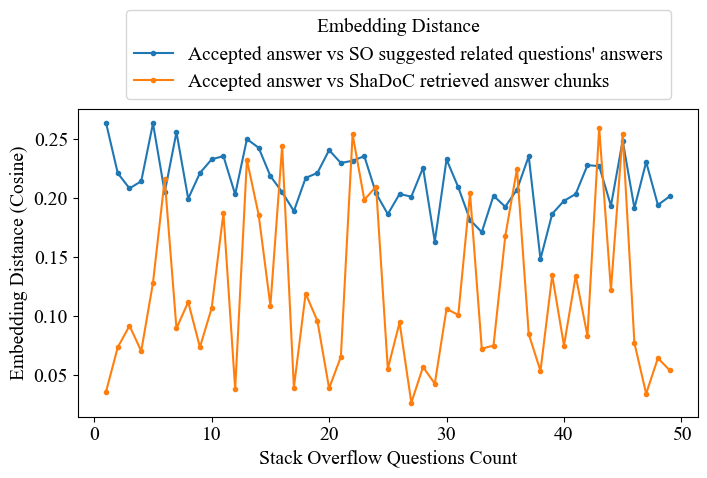

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lib.global_settings as settings

# Set font style to Times New Roman
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["font.size"] = 14  # Adjust font size as desired

fig, ax = plt.subplots(figsize=(8, 4))
# ax = plt.gca()

df = pd.read_csv(os.path.join(settings.DATA_PATH, "question_retrieval_eval_dataset.csv"))
df_new = df.drop([0])
df_new.plot(y='avg_related_emb_dist', style='.-', ax=ax, label="Accepted answer vs SO suggested related questions' answers")
df_new.plot(y='avg_relevant_emb_dist', style='.-', ax=ax, label="Accepted answer vs ShaDoC retrieved answer chunks")
plt.ylabel("Embedding Distance (Cosine)")
plt.xlabel("Stack Overflow Questions Count")
plt.legend(title="Embedding Distance", bbox_to_anchor=(0.062, 1))
plt.savefig(os.path.join(settings.DATA_PATH, "embed_dist_lineplot.pdf"), format="pdf", bbox_inches="tight")
plt.show()



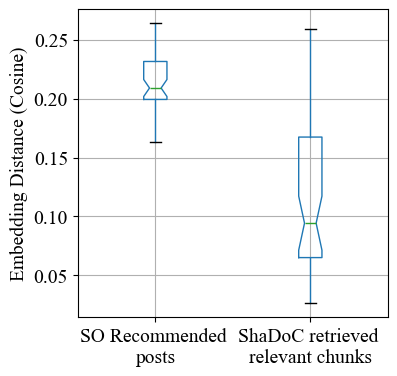

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
df_new.boxplot(column=['avg_related_emb_dist', 'avg_relevant_emb_dist'], notch=True, showfliers=False, flierprops=dict(marker="o", markerfacecolor="red", markersize=8))
plt.ylabel("Embedding Distance (Cosine)")
ax.set_xticklabels(["SO Recommended \nposts", "ShaDoC retrieved \nrelevant chunks"])
plt.savefig(os.path.join(settings.DATA_PATH, "embed_dist_boxplot.pdf"), format="pdf", bbox_inches="tight")
plt.show()

In [72]:
import pingouin as pg

# Same as before, replace with your data and column names
mw_test = pg.mwu(df_new['avg_related_emb_dist'], df_new['avg_relevant_emb_dist'])
print(mw_test)


      U-val alternative         p-val       RBC      CLES
MWU  2055.0   two-sided  1.296341e-09 -0.711787  0.855893
